In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../../data_in/CE_Crateus.csv'
data_output_path = '../../data_out/weather.csv'
data_output_path_npsave = '../../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

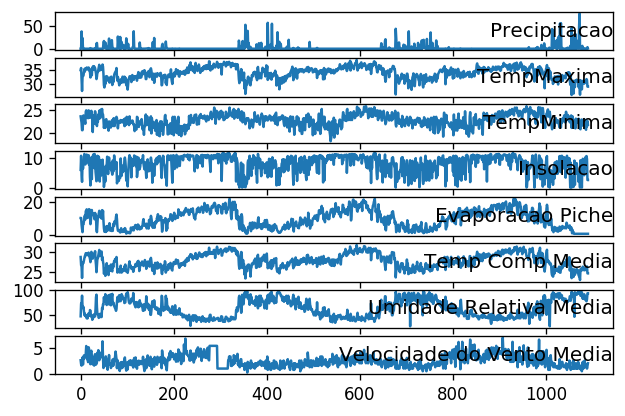

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return (x_train, y_train, x_test, y_test)

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler.inverse_transform(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nMinimum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))

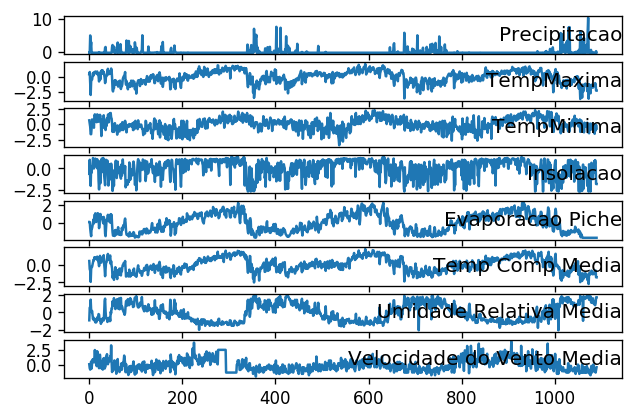

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7653 - mean_squared_error: 0.8980 - val_loss: 0.8614 - val_mean_squared_error: 1.4390
Epoch 2/1000
 - 0s - loss: 0.6994 - mean_squared_error: 0.7653 - val_loss: 0.8237 - val_mean_squared_error: 1.3539
Epoch 3/1000
 - 1s - loss: 0.6454 - mean_squared_error: 0.6667 - val_loss: 0.8967 - val_mean_squared_error: 1.4080
Epoch 4/1000
 - 0s - loss: 0.5895 - mean_squared_error: 0.5805 - val_loss: 0.8488 - val_mean_squared_error: 1.3572
Epoch 5/1000
 - 0s - loss: 0.5608 - mean_squared_error: 0.5477 - val_loss: 0.8527 - val_mean_squared_error: 1.4001
Epoch 6/1000
 - 0s - loss: 0.5542 - mean_squared_error: 0.5363 - val_loss: 0.8649 - val_mean_squared_error: 1.4740
Epoch 7/1000
 - 0s - loss: 0.5476 - mean_squared_error: 0.5287 - val_loss: 0.8932 - val_mean_squared_error: 1.5768
Epoch 8/1000
 - 0s - loss: 0.5388 - mean_squared_error: 0.5126 - val_loss: 0.9471 - val_mean_squared_error: 1.6754
Epoch 9/1000
 - 0s - loss: 0.5306 -

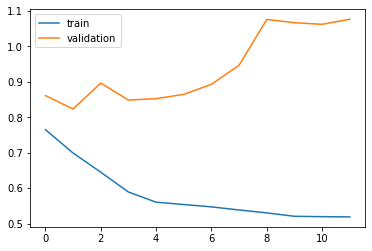


predict: [[-4.29357757 33.63906203]]
real:      [[-14.21823396  32.37202343]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7684 - mean_squared_error: 0.9298 - val_loss: 0.6828 - val_mean_squared_error: 0.4695
Epoch 2/1000
 - 0s - loss: 0.6268 - mean_squared_error: 0.6489 - val_loss: 0.8112 - val_mean_squared_error: 0.6655
Epoch 3/1000
 - 0s - loss: 0.5695 - mean_squared_error: 0.5524 - val_loss: 0.7726 - val_mean_squared_error: 0.6145
Epoch 4/1000
 - 0s - loss: 0.5539 - mean_squared_error: 0.5345 - val_loss: 0.8461 - val_mean_squared_error: 0.7227
Epoch 5/1000
 - 0s - loss: 0.5420 - mean_squared_error: 0.5064 - val_loss: 0.8714 - val_mean_squared_error: 0.7594
Epoch 6/1000
 - 0s - loss: 0.5366 - mean_squared_error: 0.5043 - val_loss: 0.9013 - val_mean_squared_error: 0.8137
Epoch 7/1000
 - 0s - loss: 0.5228 - mean_squared_error: 0.4821 - val_loss: 0.8097 - val_mean_squared_error: 0.6560
Epoch 8/1000
 - 0s - loss: 0.5172 - mean_squared_error: 0.4700 - val_l

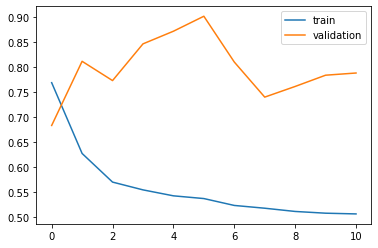


predict: [[-2.44980431 33.31753226]]
real:      [[-14.21823396  33.70050329]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7710 - mean_squared_error: 0.9233 - val_loss: 0.4624 - val_mean_squared_error: 0.2709
Epoch 2/1000
 - 0s - loss: 0.6355 - mean_squared_error: 0.6723 - val_loss: 0.3275 - val_mean_squared_error: 0.1349
Epoch 3/1000
 - 0s - loss: 0.5787 - mean_squared_error: 0.5695 - val_loss: 0.3626 - val_mean_squared_error: 0.1492
Epoch 4/1000
 - 0s - loss: 0.5669 - mean_squared_error: 0.5521 - val_loss: 0.3582 - val_mean_squared_error: 0.1650
Epoch 5/1000
 - 0s - loss: 0.5510 - mean_squared_error: 0.5311 - val_loss: 0.3600 - val_mean_squared_error: 0.1583
Epoch 6/1000
 - 0s - loss: 0.5432 - mean_squared_error: 0.5096 - val_loss: 0.3348 - val_mean_squared_error: 0.1579
Epoch 7/1000
 - 0s - loss: 0.5389 - mean_squared_error: 0.5093 - val_loss: 0.3876 - val_mean_squared_error: 0.1817
Epoch 8/1000
 - 0s - loss: 0.5326 - mean_squared_error: 0.4947 - val_l

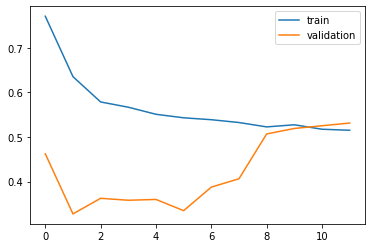


predict: [[-4.03299872 33.73701121]]
real:      [[-6.557701  31.7077835]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7581 - mean_squared_error: 0.8869 - val_loss: 1.1452 - val_mean_squared_error: 1.4070
Epoch 2/1000
 - 0s - loss: 0.6706 - mean_squared_error: 0.7146 - val_loss: 1.0720 - val_mean_squared_error: 1.2896
Epoch 3/1000
 - 0s - loss: 0.5852 - mean_squared_error: 0.5778 - val_loss: 1.0972 - val_mean_squared_error: 1.3229
Epoch 4/1000
 - 0s - loss: 0.5581 - mean_squared_error: 0.5415 - val_loss: 1.0708 - val_mean_squared_error: 1.2542
Epoch 5/1000
 - 0s - loss: 0.5465 - mean_squared_error: 0.5169 - val_loss: 1.1077 - val_mean_squared_error: 1.3300
Epoch 6/1000
 - 0s - loss: 0.5395 - mean_squared_error: 0.5085 - val_loss: 1.1251 - val_mean_squared_error: 1.3161
Epoch 7/1000
 - 0s - loss: 0.5336 - mean_squared_error: 0.4978 - val_loss: 1.1392 - val_mean_squared_error: 1.3226
Epoch 8/1000
 - 0s - loss: 0.5292 - mean_squared_error: 0.4877 - val_loss:

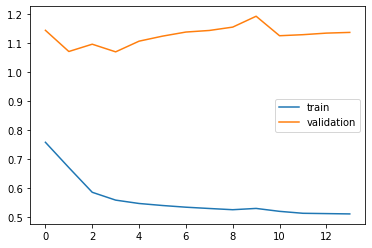


predict: [[-4.6297599  33.72030018]]
real:      [[-5.2809455  34.03262326]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7318 - mean_squared_error: 0.8396 - val_loss: 1.1567 - val_mean_squared_error: 1.4000
Epoch 2/1000
 - 0s - loss: 0.6315 - mean_squared_error: 0.6550 - val_loss: 1.1826 - val_mean_squared_error: 1.4203
Epoch 3/1000
 - 0s - loss: 0.5708 - mean_squared_error: 0.5540 - val_loss: 1.2072 - val_mean_squared_error: 1.4741
Epoch 4/1000
 - 0s - loss: 0.5527 - mean_squared_error: 0.5301 - val_loss: 1.2834 - val_mean_squared_error: 1.6484
Epoch 5/1000
 - 0s - loss: 0.5402 - mean_squared_error: 0.5115 - val_loss: 1.2585 - val_mean_squared_error: 1.5878
Epoch 6/1000
 - 0s - loss: 0.5301 - mean_squared_error: 0.4933 - val_loss: 1.2569 - val_mean_squared_error: 1.5881
Epoch 7/1000
 - 0s - loss: 0.5199 - mean_squared_error: 0.4720 - val_loss: 1.1973 - val_mean_squared_error: 1.4599
Epoch 8/1000
 - 0s - loss: 0.5161 - mean_squared_error: 0.4703 - val_los

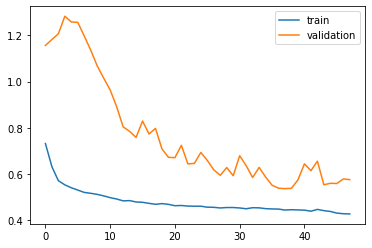


predict: [[-4.25533095 33.14036425]]
real:      [[-7.51526762 30.54536362]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6974 - mean_squared_error: 0.8068 - val_loss: 0.9815 - val_mean_squared_error: 0.9641
Epoch 2/1000
 - 1s - loss: 0.5999 - mean_squared_error: 0.6271 - val_loss: 0.8776 - val_mean_squared_error: 0.7749
Epoch 3/1000
 - 1s - loss: 0.5708 - mean_squared_error: 0.5654 - val_loss: 0.8305 - val_mean_squared_error: 0.6932
Epoch 4/1000
 - 1s - loss: 0.5552 - mean_squared_error: 0.5405 - val_loss: 0.8730 - val_mean_squared_error: 0.7713
Epoch 5/1000
 - 0s - loss: 0.5416 - mean_squared_error: 0.5153 - val_loss: 0.8419 - val_mean_squared_error: 0.7166
Epoch 6/1000
 - 1s - loss: 0.5373 - mean_squared_error: 0.5064 - val_loss: 0.8391 - val_mean_squared_error: 0.7128
Epoch 7/1000
 - 0s - loss: 0.5295 - mean_squared_error: 0.4964 - val_loss: 0.8617 - val_mean_squared_error: 0.7666
Epoch 8/1000
 - 0s - loss: 0.5260 - mean_squared_error: 0.4848 - val_los

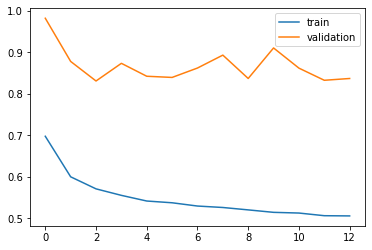


predict: [[-4.43595865 33.81775417]]
real:      [[-8.47283424 30.87748359]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7177 - mean_squared_error: 0.8504 - val_loss: 0.8144 - val_mean_squared_error: 0.8959
Epoch 2/1000
 - 1s - loss: 0.6167 - mean_squared_error: 0.6567 - val_loss: 0.6364 - val_mean_squared_error: 0.5439
Epoch 3/1000
 - 1s - loss: 0.5765 - mean_squared_error: 0.5759 - val_loss: 0.6339 - val_mean_squared_error: 0.5080
Epoch 4/1000
 - 1s - loss: 0.5568 - mean_squared_error: 0.5453 - val_loss: 0.6847 - val_mean_squared_error: 0.5839
Epoch 5/1000
 - 0s - loss: 0.5466 - mean_squared_error: 0.5229 - val_loss: 0.6254 - val_mean_squared_error: 0.4989
Epoch 6/1000
 - 0s - loss: 0.5367 - mean_squared_error: 0.5052 - val_loss: 0.6604 - val_mean_squared_error: 0.6433
Epoch 7/1000
 - 1s - loss: 0.5311 - mean_squared_error: 0.4916 - val_loss: 0.6408 - val_mean_squared_error: 0.5643
Epoch 8/1000
 - 1s - loss: 0.5282 - mean_squared_error: 0.4921 - val_los

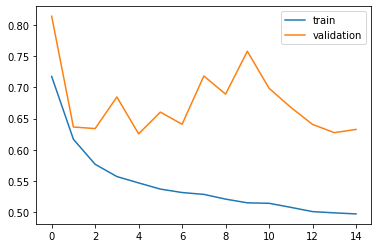


predict: [[-4.26939384 33.91460295]]
real:      [[-8.79202311 32.03990347]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7352 - mean_squared_error: 0.8770 - val_loss: 0.7722 - val_mean_squared_error: 1.1643
Epoch 2/1000
 - 0s - loss: 0.6115 - mean_squared_error: 0.6320 - val_loss: 0.7148 - val_mean_squared_error: 0.8014
Epoch 3/1000
 - 0s - loss: 0.5701 - mean_squared_error: 0.5537 - val_loss: 0.6643 - val_mean_squared_error: 0.6147
Epoch 4/1000
 - 0s - loss: 0.5485 - mean_squared_error: 0.5222 - val_loss: 0.7201 - val_mean_squared_error: 0.7416
Epoch 5/1000
 - 0s - loss: 0.5380 - mean_squared_error: 0.5060 - val_loss: 0.7886 - val_mean_squared_error: 0.8241
Epoch 6/1000
 - 1s - loss: 0.5247 - mean_squared_error: 0.4852 - val_loss: 0.8477 - val_mean_squared_error: 0.8856
Epoch 7/1000
 - 1s - loss: 0.5223 - mean_squared_error: 0.4794 - val_loss: 0.7820 - val_mean_squared_error: 0.8337
Epoch 8/1000
 - 0s - loss: 0.5212 - mean_squared_error: 0.4838 - val_los

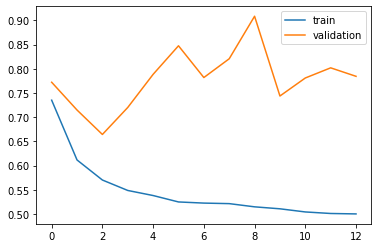


predict: [[-3.74663023 33.57197821]]
real:      [[-9.74958973 33.03626336]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7736 - mean_squared_error: 0.9497 - val_loss: 0.3826 - val_mean_squared_error: 0.2790
Epoch 2/1000
 - 0s - loss: 0.6793 - mean_squared_error: 0.7411 - val_loss: 0.5226 - val_mean_squared_error: 0.4679
Epoch 3/1000
 - 0s - loss: 0.6247 - mean_squared_error: 0.6446 - val_loss: 0.5226 - val_mean_squared_error: 0.4759
Epoch 4/1000
 - 0s - loss: 0.5679 - mean_squared_error: 0.5561 - val_loss: 0.6160 - val_mean_squared_error: 0.6395
Epoch 5/1000
 - 0s - loss: 0.5370 - mean_squared_error: 0.5124 - val_loss: 0.6472 - val_mean_squared_error: 0.6999
Epoch 6/1000
 - 0s - loss: 0.5253 - mean_squared_error: 0.4892 - val_loss: 0.6790 - val_mean_squared_error: 0.6549
Epoch 7/1000
 - 0s - loss: 0.5235 - mean_squared_error: 0.4874 - val_loss: 0.6717 - val_mean_squared_error: 0.6337
Epoch 8/1000
 - 0s - loss: 0.5186 - mean_squared_error: 0.4747 - val_los

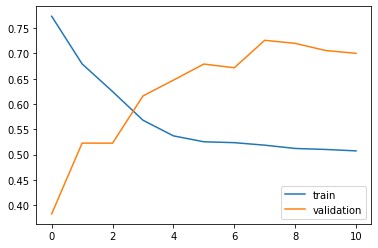


predict: [[-4.07808484 33.6268755 ]]
real:      [[-10.70715635  34.36474322]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7493 - mean_squared_error: 0.8983 - val_loss: 0.5536 - val_mean_squared_error: 0.3763
Epoch 2/1000
 - 0s - loss: 0.6198 - mean_squared_error: 0.6488 - val_loss: 0.4558 - val_mean_squared_error: 0.2286
Epoch 3/1000
 - 0s - loss: 0.5789 - mean_squared_error: 0.5726 - val_loss: 0.4714 - val_mean_squared_error: 0.2381
Epoch 4/1000
 - 1s - loss: 0.5535 - mean_squared_error: 0.5319 - val_loss: 0.4893 - val_mean_squared_error: 0.2536
Epoch 5/1000
 - 0s - loss: 0.5389 - mean_squared_error: 0.5109 - val_loss: 0.5091 - val_mean_squared_error: 0.2856
Epoch 6/1000
 - 1s - loss: 0.5371 - mean_squared_error: 0.5012 - val_loss: 0.6675 - val_mean_squared_error: 0.4731
Epoch 7/1000
 - 0s - loss: 0.5346 - mean_squared_error: 0.5111 - val_loss: 0.5675 - val_mean_squared_error: 0.3475
Epoch 8/1000
 - 0s - loss: 0.5255 - mean_squared_error: 0.4929 - val_l

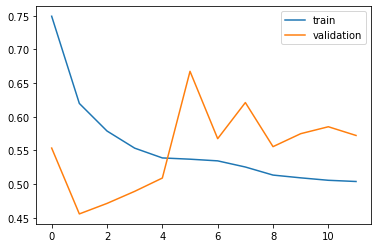


predict: [[-4.23085889 33.60806227]]
real:      [[-7.19607874 33.86656328]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7224 - mean_squared_error: 0.8247 - val_loss: 0.4166 - val_mean_squared_error: 0.3013
Epoch 2/1000
 - 0s - loss: 0.6380 - mean_squared_error: 0.6780 - val_loss: 0.4423 - val_mean_squared_error: 0.3285
Epoch 3/1000
 - 0s - loss: 0.5827 - mean_squared_error: 0.5816 - val_loss: 0.4078 - val_mean_squared_error: 0.2991
Epoch 4/1000
 - 0s - loss: 0.5522 - mean_squared_error: 0.5386 - val_loss: 0.4173 - val_mean_squared_error: 0.3103
Epoch 5/1000
 - 0s - loss: 0.5414 - mean_squared_error: 0.5203 - val_loss: 0.4159 - val_mean_squared_error: 0.3243
Epoch 6/1000
 - 0s - loss: 0.5292 - mean_squared_error: 0.5018 - val_loss: 0.4092 - val_mean_squared_error: 0.3346
Epoch 7/1000
 - 0s - loss: 0.5346 - mean_squared_error: 0.5076 - val_loss: 0.4109 - val_mean_squared_error: 0.3355
Epoch 8/1000
 - 0s - loss: 0.5253 - mean_squared_error: 0.4956 - val_los

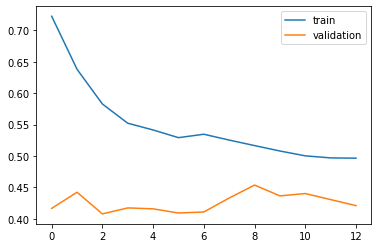


predict: [[-4.15792851 33.75341888]]
real:      [[-7.19607874 33.03626336]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7889 - mean_squared_error: 0.9685 - val_loss: 0.7544 - val_mean_squared_error: 0.5809
Epoch 2/1000
 - 0s - loss: 0.6569 - mean_squared_error: 0.7080 - val_loss: 0.7557 - val_mean_squared_error: 0.5711
Epoch 3/1000
 - 1s - loss: 0.5917 - mean_squared_error: 0.5904 - val_loss: 0.8179 - val_mean_squared_error: 0.6696
Epoch 4/1000
 - 0s - loss: 0.5532 - mean_squared_error: 0.5340 - val_loss: 0.8801 - val_mean_squared_error: 0.7746
Epoch 5/1000
 - 1s - loss: 0.5440 - mean_squared_error: 0.5238 - val_loss: 0.8306 - val_mean_squared_error: 0.6904
Epoch 6/1000
 - 0s - loss: 0.5366 - mean_squared_error: 0.5099 - val_loss: 0.8658 - val_mean_squared_error: 0.7523
Epoch 7/1000
 - 0s - loss: 0.5333 - mean_squared_error: 0.5012 - val_loss: 0.8221 - val_mean_squared_error: 0.6869
Epoch 8/1000
 - 0s - loss: 0.5231 - mean_squared_error: 0.4921 - val_los

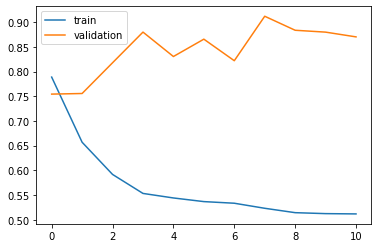


predict: [[-3.48759118 33.39192801]]
real:      [[-7.51526762 33.86656328]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7220 - mean_squared_error: 0.8269 - val_loss: 1.1745 - val_mean_squared_error: 2.4763
Epoch 2/1000
 - 0s - loss: 0.6203 - mean_squared_error: 0.6405 - val_loss: 1.1677 - val_mean_squared_error: 2.5782
Epoch 3/1000
 - 0s - loss: 0.5750 - mean_squared_error: 0.5690 - val_loss: 1.1438 - val_mean_squared_error: 2.5060
Epoch 4/1000
 - 0s - loss: 0.5487 - mean_squared_error: 0.5317 - val_loss: 1.1584 - val_mean_squared_error: 2.5843
Epoch 5/1000
 - 0s - loss: 0.5345 - mean_squared_error: 0.5105 - val_loss: 1.2201 - val_mean_squared_error: 2.6925
Epoch 6/1000
 - 0s - loss: 0.5279 - mean_squared_error: 0.4952 - val_loss: 1.2293 - val_mean_squared_error: 2.5781
Epoch 7/1000
 - 0s - loss: 0.5174 - mean_squared_error: 0.4820 - val_loss: 1.2095 - val_mean_squared_error: 2.3508
Epoch 8/1000
 - 0s - loss: 0.5130 - mean_squared_error: 0.4684 - val_los

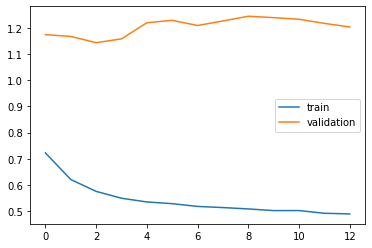


predict: [[-3.94338951 33.86268947]]
real:      [[-8.47283424 32.03990347]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7595 - mean_squared_error: 0.9076 - val_loss: 0.8408 - val_mean_squared_error: 1.2652
Epoch 2/1000
 - 0s - loss: 0.6232 - mean_squared_error: 0.6519 - val_loss: 0.8791 - val_mean_squared_error: 1.2789
Epoch 3/1000
 - 0s - loss: 0.5698 - mean_squared_error: 0.5633 - val_loss: 0.9072 - val_mean_squared_error: 1.2237
Epoch 4/1000
 - 0s - loss: 0.5441 - mean_squared_error: 0.5242 - val_loss: 0.9163 - val_mean_squared_error: 1.2969
Epoch 5/1000
 - 0s - loss: 0.5320 - mean_squared_error: 0.5049 - val_loss: 1.0030 - val_mean_squared_error: 1.3796
Epoch 6/1000
 - 0s - loss: 0.5231 - mean_squared_error: 0.4914 - val_loss: 0.9841 - val_mean_squared_error: 1.3127
Epoch 7/1000
 - 0s - loss: 0.5190 - mean_squared_error: 0.4828 - val_loss: 0.9285 - val_mean_squared_error: 1.1866
Epoch 8/1000
 - 0s - loss: 0.5136 - mean_squared_error: 0.4794 - val_los

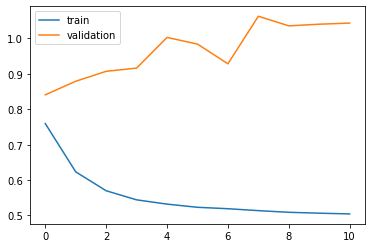


predict: [[-3.76844711 33.94053315]]
real:      [[-17.41012269  34.19868324]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7220 - mean_squared_error: 0.8208 - val_loss: 0.7589 - val_mean_squared_error: 0.5759
Epoch 2/1000
 - 0s - loss: 0.6392 - mean_squared_error: 0.6671 - val_loss: 0.8974 - val_mean_squared_error: 0.8070
Epoch 3/1000
 - 0s - loss: 0.5735 - mean_squared_error: 0.5656 - val_loss: 0.9191 - val_mean_squared_error: 0.8526
Epoch 4/1000
 - 0s - loss: 0.5481 - mean_squared_error: 0.5295 - val_loss: 0.7525 - val_mean_squared_error: 0.5698
Epoch 5/1000
 - 0s - loss: 0.5379 - mean_squared_error: 0.5051 - val_loss: 0.8353 - val_mean_squared_error: 0.6983
Epoch 6/1000
 - 0s - loss: 0.5299 - mean_squared_error: 0.4994 - val_loss: 0.7780 - val_mean_squared_error: 0.6151
Epoch 7/1000
 - 0s - loss: 0.5249 - mean_squared_error: 0.4861 - val_loss: 0.8487 - val_mean_squared_error: 0.7439
Epoch 8/1000
 - 0s - loss: 0.5215 - mean_squared_error: 0.4830 - val_l

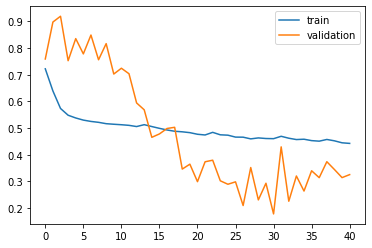


predict: [[-6.39870001 32.65970347]]
real:      [[-12.30310072  34.19868324]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7815 - mean_squared_error: 0.9482 - val_loss: 0.9856 - val_mean_squared_error: 1.4038
Epoch 2/1000
 - 0s - loss: 0.6698 - mean_squared_error: 0.7115 - val_loss: 1.0422 - val_mean_squared_error: 1.3477
Epoch 3/1000
 - 0s - loss: 0.5933 - mean_squared_error: 0.5844 - val_loss: 1.0197 - val_mean_squared_error: 1.3278
Epoch 4/1000
 - 0s - loss: 0.5518 - mean_squared_error: 0.5272 - val_loss: 1.0251 - val_mean_squared_error: 1.2583
Epoch 5/1000
 - 0s - loss: 0.5324 - mean_squared_error: 0.4994 - val_loss: 1.0333 - val_mean_squared_error: 1.3114
Epoch 6/1000
 - 0s - loss: 0.5261 - mean_squared_error: 0.4886 - val_loss: 0.9454 - val_mean_squared_error: 1.1092
Epoch 7/1000
 - 0s - loss: 0.5245 - mean_squared_error: 0.4856 - val_loss: 1.0546 - val_mean_squared_error: 1.2389
Epoch 8/1000
 - 0s - loss: 0.5177 - mean_squared_error: 0.4759 - val_l

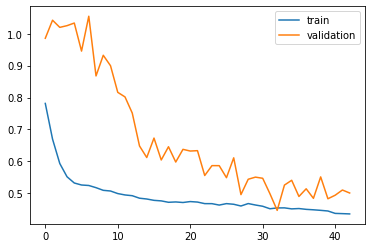


predict: [[-6.56911984 32.74888598]]
real:      [[-8.47283424 32.20596345]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7490 - mean_squared_error: 0.8761 - val_loss: 2.0897 - val_mean_squared_error: 5.3489
Epoch 2/1000
 - 0s - loss: 0.6863 - mean_squared_error: 0.7494 - val_loss: 2.1240 - val_mean_squared_error: 5.3811
Epoch 3/1000
 - 0s - loss: 0.6046 - mean_squared_error: 0.6104 - val_loss: 2.1527 - val_mean_squared_error: 5.4188
Epoch 4/1000
 - 0s - loss: 0.5537 - mean_squared_error: 0.5292 - val_loss: 2.0223 - val_mean_squared_error: 4.9251
Epoch 5/1000
 - 0s - loss: 0.5355 - mean_squared_error: 0.4951 - val_loss: 2.0970 - val_mean_squared_error: 5.2950
Epoch 6/1000
 - 0s - loss: 0.5288 - mean_squared_error: 0.4939 - val_loss: 2.1299 - val_mean_squared_error: 5.3091
Epoch 7/1000
 - 0s - loss: 0.5232 - mean_squared_error: 0.4843 - val_loss: 2.1086 - val_mean_squared_error: 5.2402
Epoch 8/1000
 - 0s - loss: 0.5204 - mean_squared_error: 0.4757 - val_los

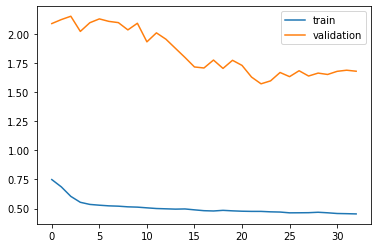


predict: [[-5.97647474 32.92587646]]
real:      [[-6.557701   30.71142361]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7357 - mean_squared_error: 0.8487 - val_loss: 1.3901 - val_mean_squared_error: 1.9905
Epoch 2/1000
 - 0s - loss: 0.6226 - mean_squared_error: 0.6381 - val_loss: 1.4129 - val_mean_squared_error: 2.0264
Epoch 3/1000
 - 0s - loss: 0.5703 - mean_squared_error: 0.5579 - val_loss: 1.3620 - val_mean_squared_error: 1.9465
Epoch 4/1000
 - 0s - loss: 0.5475 - mean_squared_error: 0.5222 - val_loss: 1.4438 - val_mean_squared_error: 2.1531
Epoch 5/1000
 - 0s - loss: 0.5369 - mean_squared_error: 0.5021 - val_loss: 1.4058 - val_mean_squared_error: 2.0892
Epoch 6/1000
 - 0s - loss: 0.5302 - mean_squared_error: 0.4871 - val_loss: 1.3350 - val_mean_squared_error: 1.8780
Epoch 7/1000
 - 0s - loss: 0.5303 - mean_squared_error: 0.4848 - val_loss: 1.4473 - val_mean_squared_error: 2.2235
Epoch 8/1000
 - 0s - loss: 0.5200 - mean_squared_error: 0.4705 - val_los

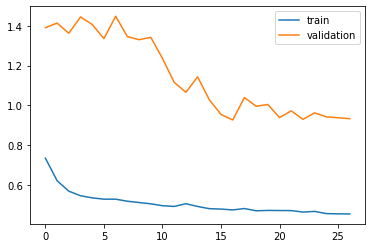


predict: [[-7.56707893 33.69309236]]
real:      [[-23.79390016  31.20960355]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7231 - mean_squared_error: 0.8366 - val_loss: 0.7365 - val_mean_squared_error: 0.5430
Epoch 2/1000
 - 0s - loss: 0.6087 - mean_squared_error: 0.6306 - val_loss: 0.7795 - val_mean_squared_error: 0.6079
Epoch 3/1000
 - 0s - loss: 0.5755 - mean_squared_error: 0.5729 - val_loss: 0.7343 - val_mean_squared_error: 0.5397
Epoch 4/1000
 - 0s - loss: 0.5454 - mean_squared_error: 0.5165 - val_loss: 0.7400 - val_mean_squared_error: 0.5482
Epoch 5/1000
 - 0s - loss: 0.5283 - mean_squared_error: 0.4886 - val_loss: 0.6923 - val_mean_squared_error: 0.4794
Epoch 6/1000
 - 0s - loss: 0.5213 - mean_squared_error: 0.4723 - val_loss: 0.7252 - val_mean_squared_error: 0.5259
Epoch 7/1000
 - 0s - loss: 0.5219 - mean_squared_error: 0.4788 - val_loss: 0.7177 - val_mean_squared_error: 0.5169
Epoch 8/1000
 - 0s - loss: 0.5131 - mean_squared_error: 0.4613 - val_l

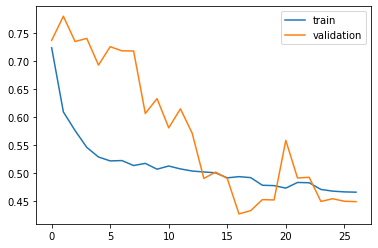


predict: [[-4.09072608 33.17268088]]
real:      [[-13.26066734  31.04354357]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7743 - mean_squared_error: 0.9375 - val_loss: 1.3068 - val_mean_squared_error: 2.8336
Epoch 2/1000
 - 0s - loss: 0.6702 - mean_squared_error: 0.7416 - val_loss: 1.0933 - val_mean_squared_error: 2.3630
Epoch 3/1000
 - 0s - loss: 0.6022 - mean_squared_error: 0.6234 - val_loss: 1.0512 - val_mean_squared_error: 1.8855
Epoch 4/1000
 - 0s - loss: 0.5672 - mean_squared_error: 0.5510 - val_loss: 1.0075 - val_mean_squared_error: 1.5556
Epoch 5/1000
 - 0s - loss: 0.5444 - mean_squared_error: 0.5193 - val_loss: 1.0105 - val_mean_squared_error: 1.5556
Epoch 6/1000
 - 0s - loss: 0.5334 - mean_squared_error: 0.4954 - val_loss: 1.0782 - val_mean_squared_error: 1.8107
Epoch 7/1000
 - 0s - loss: 0.5313 - mean_squared_error: 0.4939 - val_loss: 1.0786 - val_mean_squared_error: 1.8130
Epoch 8/1000
 - 0s - loss: 0.5226 - mean_squared_error: 0.4757 - val_l

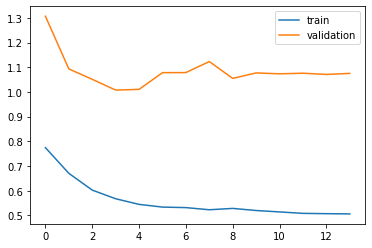


predict: [[-3.82009335 33.14621823]]
real:      [[-7.19607874 32.03990347]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7503 - mean_squared_error: 0.8725 - val_loss: 0.6667 - val_mean_squared_error: 0.6015
Epoch 2/1000
 - 0s - loss: 0.6561 - mean_squared_error: 0.6823 - val_loss: 0.4468 - val_mean_squared_error: 0.2514
Epoch 3/1000
 - 0s - loss: 0.5987 - mean_squared_error: 0.6057 - val_loss: 0.5200 - val_mean_squared_error: 0.2988
Epoch 4/1000
 - 0s - loss: 0.5494 - mean_squared_error: 0.5150 - val_loss: 0.4437 - val_mean_squared_error: 0.2239
Epoch 5/1000
 - 0s - loss: 0.5351 - mean_squared_error: 0.4874 - val_loss: 0.4653 - val_mean_squared_error: 0.2435
Epoch 6/1000
 - 0s - loss: 0.5244 - mean_squared_error: 0.4764 - val_loss: 0.5053 - val_mean_squared_error: 0.2928
Epoch 7/1000
 - 0s - loss: 0.5230 - mean_squared_error: 0.4775 - val_loss: 0.4803 - val_mean_squared_error: 0.2611
Epoch 8/1000
 - 0s - loss: 0.5210 - mean_squared_error: 0.4745 - val_los

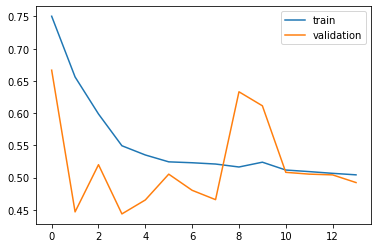


predict: [[-5.62247729 33.3942133 ]]
real:      [[-14.8566117   34.53080321]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7085 - mean_squared_error: 0.8014 - val_loss: 0.5357 - val_mean_squared_error: 0.2873
Epoch 2/1000
 - 0s - loss: 0.6057 - mean_squared_error: 0.6074 - val_loss: 0.5009 - val_mean_squared_error: 0.2526
Epoch 3/1000
 - 0s - loss: 0.5559 - mean_squared_error: 0.5349 - val_loss: 0.3800 - val_mean_squared_error: 0.1453
Epoch 4/1000
 - 0s - loss: 0.5355 - mean_squared_error: 0.4990 - val_loss: 0.5129 - val_mean_squared_error: 0.2715
Epoch 5/1000
 - 0s - loss: 0.5241 - mean_squared_error: 0.4920 - val_loss: 0.4538 - val_mean_squared_error: 0.2095
Epoch 6/1000
 - 0s - loss: 0.5181 - mean_squared_error: 0.4779 - val_loss: 0.4634 - val_mean_squared_error: 0.2175
Epoch 7/1000
 - 0s - loss: 0.5129 - mean_squared_error: 0.4756 - val_loss: 0.4321 - val_mean_squared_error: 0.1873
Epoch 8/1000
 - 0s - loss: 0.5067 - mean_squared_error: 0.4649 - val_l

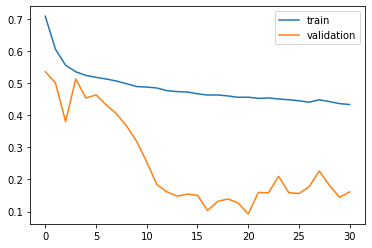


predict: [[-5.95663997 33.45647959]]
real:      [[-6.87688987 33.03626336]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7246 - mean_squared_error: 0.8519 - val_loss: 0.5690 - val_mean_squared_error: 0.4610
Epoch 2/1000
 - 0s - loss: 0.6054 - mean_squared_error: 0.6036 - val_loss: 0.3801 - val_mean_squared_error: 0.2803
Epoch 3/1000
 - 0s - loss: 0.5588 - mean_squared_error: 0.5302 - val_loss: 0.4186 - val_mean_squared_error: 0.2498
Epoch 4/1000
 - 0s - loss: 0.5384 - mean_squared_error: 0.4982 - val_loss: 0.3870 - val_mean_squared_error: 0.2678
Epoch 5/1000
 - 0s - loss: 0.5286 - mean_squared_error: 0.4839 - val_loss: 0.3620 - val_mean_squared_error: 0.2360
Epoch 6/1000
 - 0s - loss: 0.5265 - mean_squared_error: 0.4841 - val_loss: 0.3400 - val_mean_squared_error: 0.2240
Epoch 7/1000
 - 0s - loss: 0.5178 - mean_squared_error: 0.4709 - val_loss: 0.3357 - val_mean_squared_error: 0.1997
Epoch 8/1000
 - 0s - loss: 0.5136 - mean_squared_error: 0.4663 - val_los

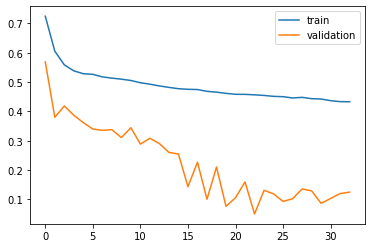


predict: [[-6.49797452 33.12366436]]
real:      [[-7.19607874 33.03626336]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7601 - mean_squared_error: 0.8904 - val_loss: 0.3765 - val_mean_squared_error: 0.1907
Epoch 2/1000
 - 0s - loss: 0.6503 - mean_squared_error: 0.6986 - val_loss: 0.3157 - val_mean_squared_error: 0.1143
Epoch 3/1000
 - 0s - loss: 0.5736 - mean_squared_error: 0.5668 - val_loss: 0.3628 - val_mean_squared_error: 0.1336
Epoch 4/1000
 - 0s - loss: 0.5468 - mean_squared_error: 0.5228 - val_loss: 0.3296 - val_mean_squared_error: 0.1112
Epoch 5/1000
 - 0s - loss: 0.5329 - mean_squared_error: 0.5033 - val_loss: 0.3679 - val_mean_squared_error: 0.1432
Epoch 6/1000
 - 0s - loss: 0.5261 - mean_squared_error: 0.4849 - val_loss: 0.2873 - val_mean_squared_error: 0.0850
Epoch 7/1000
 - 0s - loss: 0.5193 - mean_squared_error: 0.4798 - val_loss: 0.3998 - val_mean_squared_error: 0.1663
Epoch 8/1000
 - 0s - loss: 0.5143 - mean_squared_error: 0.4701 - val_los

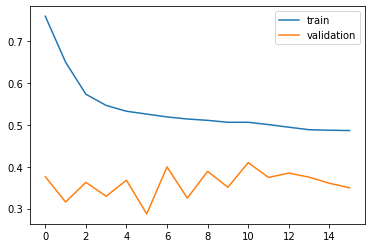


predict: [[-5.15462121 33.48128076]]
real:      [[-7.51526762 33.86656328]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7459 - mean_squared_error: 0.8660 - val_loss: 0.6862 - val_mean_squared_error: 0.7641
Epoch 2/1000
 - 0s - loss: 0.6491 - mean_squared_error: 0.6883 - val_loss: 0.6533 - val_mean_squared_error: 0.6227
Epoch 3/1000
 - 0s - loss: 0.5943 - mean_squared_error: 0.5913 - val_loss: 0.5437 - val_mean_squared_error: 0.4201
Epoch 4/1000
 - 0s - loss: 0.5569 - mean_squared_error: 0.5265 - val_loss: 0.3764 - val_mean_squared_error: 0.2637
Epoch 5/1000
 - 0s - loss: 0.5352 - mean_squared_error: 0.4980 - val_loss: 0.4053 - val_mean_squared_error: 0.2348
Epoch 6/1000
 - 0s - loss: 0.5262 - mean_squared_error: 0.4845 - val_loss: 0.3854 - val_mean_squared_error: 0.2204
Epoch 7/1000
 - 0s - loss: 0.5219 - mean_squared_error: 0.4810 - val_loss: 0.4145 - val_mean_squared_error: 0.2355
Epoch 8/1000
 - 0s - loss: 0.5204 - mean_squared_error: 0.4788 - val_los

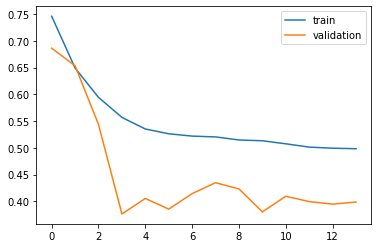


predict: [[-3.13038447 33.73295004]]
real:      [[-5.91932325 34.19868324]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7118 - mean_squared_error: 0.8380 - val_loss: 0.7048 - val_mean_squared_error: 0.6592
Epoch 2/1000
 - 0s - loss: 0.5972 - mean_squared_error: 0.6139 - val_loss: 0.5051 - val_mean_squared_error: 0.3384
Epoch 3/1000
 - 0s - loss: 0.5527 - mean_squared_error: 0.5303 - val_loss: 0.3336 - val_mean_squared_error: 0.1244
Epoch 4/1000
 - 0s - loss: 0.5392 - mean_squared_error: 0.5046 - val_loss: 0.3522 - val_mean_squared_error: 0.2007
Epoch 5/1000
 - 0s - loss: 0.5273 - mean_squared_error: 0.4904 - val_loss: 0.3989 - val_mean_squared_error: 0.2012
Epoch 6/1000
 - 0s - loss: 0.5239 - mean_squared_error: 0.4881 - val_loss: 0.4066 - val_mean_squared_error: 0.1739
Epoch 7/1000
 - 0s - loss: 0.5124 - mean_squared_error: 0.4720 - val_loss: 0.3904 - val_mean_squared_error: 0.1855
Epoch 8/1000
 - 0s - loss: 0.5055 - mean_squared_error: 0.4685 - val_los

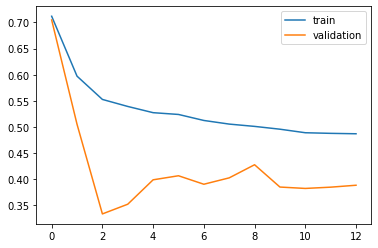


predict: [[-5.93621914 33.33245452]]
real:      [[-7.83445649 34.03262326]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7042 - mean_squared_error: 0.7869 - val_loss: 1.0268 - val_mean_squared_error: 1.2130
Epoch 2/1000
 - 0s - loss: 0.6047 - mean_squared_error: 0.6054 - val_loss: 0.9067 - val_mean_squared_error: 0.9513
Epoch 3/1000
 - 0s - loss: 0.5456 - mean_squared_error: 0.5070 - val_loss: 0.8355 - val_mean_squared_error: 0.8372
Epoch 4/1000
 - 0s - loss: 0.5314 - mean_squared_error: 0.4868 - val_loss: 0.9347 - val_mean_squared_error: 1.0055
Epoch 5/1000
 - 0s - loss: 0.5236 - mean_squared_error: 0.4812 - val_loss: 0.8240 - val_mean_squared_error: 0.8214
Epoch 6/1000
 - 0s - loss: 0.5183 - mean_squared_error: 0.4699 - val_loss: 0.7777 - val_mean_squared_error: 0.7425
Epoch 7/1000
 - 0s - loss: 0.5155 - mean_squared_error: 0.4721 - val_loss: 0.8387 - val_mean_squared_error: 0.8474
Epoch 8/1000
 - 0s - loss: 0.5145 - mean_squared_error: 0.4617 - val_los

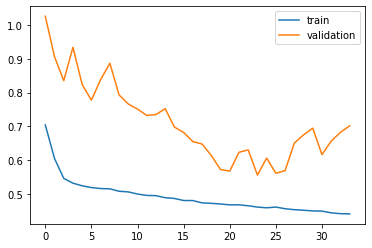


predict: [[-4.28705157 33.13504459]]
real:      [[-6.87688987 34.53080321]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7547 - mean_squared_error: 0.9235 - val_loss: 1.2515 - val_mean_squared_error: 2.7959
Epoch 2/1000
 - 0s - loss: 0.6479 - mean_squared_error: 0.6984 - val_loss: 1.2585 - val_mean_squared_error: 2.5604
Epoch 3/1000
 - 0s - loss: 0.5945 - mean_squared_error: 0.5940 - val_loss: 1.0020 - val_mean_squared_error: 1.7341
Epoch 4/1000
 - 0s - loss: 0.5533 - mean_squared_error: 0.5262 - val_loss: 0.8361 - val_mean_squared_error: 1.2670
Epoch 5/1000
 - 0s - loss: 0.5333 - mean_squared_error: 0.4978 - val_loss: 0.7778 - val_mean_squared_error: 1.1053
Epoch 6/1000
 - 0s - loss: 0.5245 - mean_squared_error: 0.4843 - val_loss: 0.7827 - val_mean_squared_error: 1.2166
Epoch 7/1000
 - 0s - loss: 0.5150 - mean_squared_error: 0.4733 - val_loss: 0.7938 - val_mean_squared_error: 1.1532
Epoch 8/1000
 - 0s - loss: 0.5078 - mean_squared_error: 0.4638 - val_los

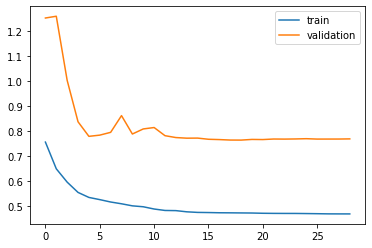


predict: [[-5.34223897 33.41218109]]
real:      [[-7.51526762 31.04354357]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7489 - mean_squared_error: 0.8592 - val_loss: 0.6600 - val_mean_squared_error: 0.6778
Epoch 2/1000
 - 0s - loss: 0.6338 - mean_squared_error: 0.6480 - val_loss: 0.5636 - val_mean_squared_error: 0.5417
Epoch 3/1000
 - 0s - loss: 0.5636 - mean_squared_error: 0.5343 - val_loss: 0.5461 - val_mean_squared_error: 0.4309
Epoch 4/1000
 - 0s - loss: 0.5403 - mean_squared_error: 0.5057 - val_loss: 0.5423 - val_mean_squared_error: 0.4627
Epoch 5/1000
 - 0s - loss: 0.5317 - mean_squared_error: 0.4937 - val_loss: 0.5176 - val_mean_squared_error: 0.5164
Epoch 6/1000
 - 0s - loss: 0.5253 - mean_squared_error: 0.4878 - val_loss: 0.4741 - val_mean_squared_error: 0.3772
Epoch 7/1000
 - 0s - loss: 0.5217 - mean_squared_error: 0.4800 - val_loss: 0.5389 - val_mean_squared_error: 0.5303
Epoch 8/1000
 - 0s - loss: 0.5131 - mean_squared_error: 0.4732 - val_los

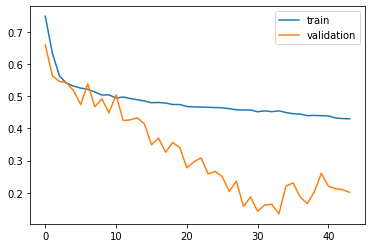


predict: [[-3.22590291 33.55010035]]
real:      [[-14.8566117   33.86656328]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7481 - mean_squared_error: 0.8661 - val_loss: 0.9698 - val_mean_squared_error: 0.9463
Epoch 2/1000
 - 0s - loss: 0.6413 - mean_squared_error: 0.6655 - val_loss: 0.7716 - val_mean_squared_error: 0.5965
Epoch 3/1000
 - 0s - loss: 0.5645 - mean_squared_error: 0.5412 - val_loss: 0.7260 - val_mean_squared_error: 0.5309
Epoch 4/1000
 - 0s - loss: 0.5450 - mean_squared_error: 0.5134 - val_loss: 0.7338 - val_mean_squared_error: 0.5385
Epoch 5/1000
 - 0s - loss: 0.5344 - mean_squared_error: 0.4963 - val_loss: 0.9069 - val_mean_squared_error: 0.8298
Epoch 6/1000
 - 0s - loss: 0.5249 - mean_squared_error: 0.4862 - val_loss: 0.7681 - val_mean_squared_error: 0.5969
Epoch 7/1000
 - 0s - loss: 0.5186 - mean_squared_error: 0.4758 - val_loss: 0.6065 - val_mean_squared_error: 0.3692
Epoch 8/1000
 - 0s - loss: 0.5084 - mean_squared_error: 0.4651 - val_l

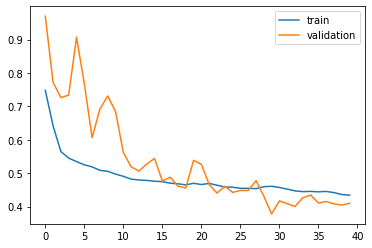


predict: [[-4.24923618 33.29977061]]
real:      [[-10.38796748  34.03262326]]

Maximum temperature
Test RMSE -------------------------- 6.577
Test VARIANCE ---------------------- -0.0008972
Test MAX-ERROR --------------------- 16.23
Test MEAN-ABSOLUTE-ERROR ----------- 5.171
Test MEDIAN-ABSOLUTE-ERROR --------- 3.702

Minimum temperature
Test RMSE -------------------------- 1.413
Test VARIANCE ---------------------- -0.03917
Test MAX-ERROR --------------------- 2.94
Test MEAN-ABSOLUTE-ERROR ----------- 1.141
Test MEDIAN-ABSOLUTE-ERROR --------- 0.7354


In [11]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

standart_scaler = preprocessing.StandardScaler()
values_scaled = standart_scaler.fit_transform(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

plot_columns(values_scaled)

NCV(dataset_scaled, days_to_predict, standart_scaler)